 # Visualising the pulsar data

You can use this notebook to visualise the frequency vs phase data you recorded from the telescope.

## Using the notebook

You can write python code in the cells. Execute the code with Ctrl-Enter. The results are displayed below the cell.

Cells can also contain annotations like this one. A cell can be toggled between code and "[markdown](https://github.com/adam-p/markdown-here/wiki/Markdown-Cheatsheet)" in the drop-down menu above. The annotation cells can be written in plain text, but also support markdown formatting, a cheat-sheet for which can be found at the above link. Double-click to edit the text, and Ctrl-Enter return to the formated version. Try it on this comment.

## Load the required libraries

We mainly make use of two libraries in this template: Numpy and matplotlib. You may be familiar with these from other courses.

Numpy provides routines for doing lots of math stuff. For example, here we use the numpy.loadtxt routine to read a text file and convert the characters to numbers with just a single line of code. Here we import the numpy library with a short name `np` 

We will import the matplotlib package as `plt` in order to use it to make all kinds of plots.

Numpy (and the related scipy) have very powerful tools for doing all kinds of operations, including fitting functions to data. You can find lots of information on these methods if you search around the web and in the numpy manual, and do talk to your demonstrator.

We don't need all these just for plotting, but some e.g. astropy might be very useful for other tasks.


In [1]:
# To begin, we import some libraries that we will need later.

# The numpy library will allow us to do FFTs
import numpy as np

# The pyplot module from matplotlib will allow us to plot things.
from  matplotlib import pyplot as plt

# pi is a useful value!
from math import pi

import os

ModuleNotFoundError: No module named 'numpy'

## Connect to your google drive to allow you to read data files

In [ ]:

#filelist = []
#for (dirpath, dirnames, filenames) in os.walk(pathcrabtemplate):
    #filelist.extend(filenames)
    #break
#print (filelist)   # Show the contents of your working directory. At least your notebook should show up here.

## Read the file and make a plot

We will use the psrchive software to load the data. The provided `load_channels()` method will read the data into a `numpy` array.

In [8]:
# Use the numpy loadtxt routine to read data.

# this is an example file, change it to point at your data.
filename=os.path.join("example_data/20260203_165003_B0329+54.npz")
obsdata = np.load(filename)
print(obsdata['header'])
print("")

data = obsdata['data']
print("Data array shape:",data.shape)

Filename                      : 20260203_165003_B0329+54.cln
Source Name                   : B0329+54
Number of channels            : 40
Number of phase bins          : 1024
Number of sub-integrations    : 3
Centre Freq (MHz)             : 611.0
Bandwidth (MHz)               : 10.0
Integration Time (s)          : 529.99986
Telescope                     : Jodrell

Data array shape: (3, 40, 1024)


### Plotting

We have read a 2-d `numpy` array which we can then plot using `matplotlib`.


The code then plots a 2-d plot showing intensity as a function of frequency and phase. This is the **phase vs frequency** plot. We can also integrate over frequency by summing along the first axis of the array. This produces **intensity vs phase** plot.

Check you understand what you are seeing in these plots. Discuss them with your demonstrator.

Nsub = 3 Nchan = 40 Nphase= 1024


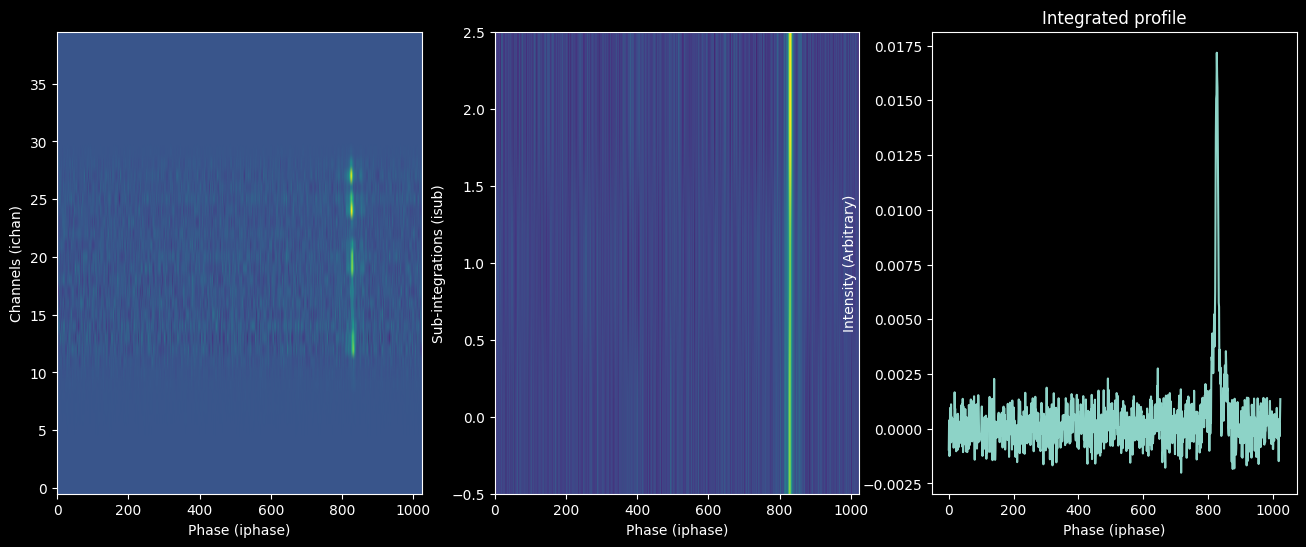

In [9]:
# Here we infer the number of channels and numnber of phase bins based on the last entry in the file.
nsub, nchan,nphase = data.shape

# Print this out for verification
print("Nsub = {} Nchan = {} Nphase= {}".format(nsub, nchan,nphase))


# Here is where we reshape the 1-d array into a 2-d data structure
iphase=np.arange(nphase)
ichan=np.arange(nchan)
isub = np.arange(nsub)

# We can integrate over all frequency channels by using the `sum` routine from numpy...
fully_averaged=np.mean(data,axis=(0,1))
time_averaged = np.mean(data,axis=0)
freq_averaged = np.mean(data,axis=1)

# Plot the 2-d data:
plt.figure(figsize=(16,6))
plt.subplot(131)
plt.imshow(time_averaged,aspect='auto',origin='lower')
plt.xlabel("Phase (iphase)")
plt.ylabel("Channels (ichan)")

plt.subplot(132)
plt.imshow(freq_averaged,aspect='auto',origin='lower')
plt.xlabel("Phase (iphase)")
plt.ylabel("Sub-integrations (isub)")

# Plot the integrated profile:
plt.subplot(133)
plt.plot(fully_averaged)
plt.xlabel("Phase (iphase)")
plt.ylabel("Intensity (Arbitrary)")
plt.title("Integrated profile")
plt.show()

## Dispersion

The pulsar signal experiences a frequency dependent delay caused by the interstellar plasma. This should be visiable in the frequency vs phase plot as a drift in the pulse as a function of frequency. This is called dispersion.

In order to measure and correct for the dispersion, you will need to convert the axes of your data to physical units.

The frequency axis can be determined from the central frequency and bandwidth of your instrument
The time axis can be determined from the period of the pulsar and the number of phase bins.


### De-dispersion
Correcting for the dispersion requires shifting the rows of your 2-d array by a frequency dependent time delay equal to the negative of the dispersion induced delay. This process is called "de-dispersion". Once de-dispersed, integrating over frequency channels should give improved signal-to-noise and a narrower pulse.

To get you started, we have provided a function `shift_rows` which will rotate each row of a 2-d matrix by the number of bins specified in the `shifts` array.

The demo program will use this to shift each row by an arbitrary amount, you will need to modify the program to shift by the time delay caused by a given "dispersion measure" (DM). Read the lab script for more information about how to compute this time delay.

Modify this program to correct the data for a given DM. Try a few values of DM (see if you can find common values for dispersion measure of pulsars) and see if you can roughly detrmine the value that maximises the DM. Check with your demonstrator if your DM value is sensible. You should extend your program to try to determine the DM in a more rigourous way. There are many ways to do this, if you are stuck, discuss with your demonstrator.

In [10]:
##
#  This function will shift each row of a 2-d (3-d) array by the the number of columns specified in the "shifts" array.
#  data_in - the 2-d (3-d) array to work on
#  shifts - the shifts to apply
#  Returns: The shifted array
##
def shift_rows(data_in, shifts):
    shifted = np.zeros_like(data_in)
    if data_in.ndim == 3:
        for sub in range(nsub):
            shifted[sub] = shift_rows(data_in[sub],shifts)
    else:
        for chan in range(nchan):
            shifted[chan] = np.roll(data_in[chan],int(shifts[chan]))
    return shifted



In [2]:
# This example scaling is wrong - you need to determine the right values to scale!
#freq = 50 + ichan * 5
# right scaling
f_c = 611        # MHz (central frequency)
bw = 10          # MHz total bandwidth

P = 0.714        # seconds, pulsar period
DM = 26        # pc cm^-3, trial dispersion measure

nchan = time_averaged.shape[0]

freq = np.linspace(
    f_c - bw/2,
    f_c + bw/2,
    nchan
)

# Time resolution per phase bin
dt = P / nphase   # seconds per bin


###############################################################################
# Compute dispersion delay
###############################################################################
# Dispersion constant
K = 4.148808e3  # ms MHz^2 pc^-1 cm^3

# Reference frequency (highest frequency channel)
nu_ref = freq.max()

# Delay relative to reference frequency
delay_s = K * DM * (freq**-2 - nu_ref**-2)

# Convert delay to phase-bin shifts (negative = de-disperse)
bindelay = -np.round(delay_s / dt).astype(int)

# This array is going to conain the phase shifts in "bins".
# For this demo, we just shift by the frequency, which is clearly not correct!
# bindelay=freq

# Here we call our row-shifting function
# Remeber that the shift is in phase bins, not time units!
dedispersed = shift_rows(time_averaged,bindelay)
# Again, sum along axis zero to integrate over frequency.
integrated=np.sum(dedispersed,axis=0)

# plot the data again... If you have de-dispersed correctly, you the S/N should be maximised.
plt.figure(figsize=(12,12))
plt.subplot(211)
plt.imshow(
    dedispersed,
    aspect='auto',
    origin='lower',
    extent=(0, P, freq[0], freq[-1])
)
plt.imshow(dedispersed,aspect='auto',origin='lower',extent=(0,1,freq[0],freq[-1]))
plt.xlabel("Time (s)") # phase
plt.ylabel("Frequency (MHz)") # frequency
plt.title(f"De-dispersed data (DM = {DM:.1f} pc cm$^{{-3}}$)")

# Integrated pulse profile
plt.subplot(212)
plt.plot(np.linspace(0, P, nphase), integrated)
plt.xlabel("Time (s)")
plt.ylabel("Intensity (arbitrary)")
plt.title("Integrated profile")

plt.tight_layout()
plt.show()



NameError: name 'time_averaged' is not defined